# Early Fusion Model - CMU-MOSEI Dataset

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 521, done.
remote: Total 521 (delta 0), reused 0 (delta 0), pack-reused 521 (from 2)
Receiving objects: 100% (521/521), 320.60 MiB | 48.49 MiB/s, done.
Resolving deltas: 100% (237/237), done.


## Importing Libraries

In [2]:
!pip install memory_profiler

In [3]:
import sys
import torch

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [4]:
from loader import get_dataloader
from unimodals.modules import GRU, MLP, Sequential, Identity
from training.supervised import train, test
from fusions.modules import ConcatEarly
from utils import get_default_device, save_results

In [5]:
import gdown

file_id = "1zFOBHijVppTiyteSsi0aTFYPEsda_AOk"
destination = "mosei_raw.pkl"  # Name to save the file as

# Download the file
gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk
From (redirected): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk&confirm=t&uuid=9ad3b0fe-1cb0-4916-b494-e58383378d6b
To: /content/mosei_raw.pkl
100%|██████████| 9.94G/9.94G [00:55<00:00, 181MB/s]


'mosei_raw.pkl'

## Loading the Dataset

In [6]:
FILE_PATH = '/content/mosei_raw.pkl'
train_data, valid_data, test_data = get_dataloader(FILE_PATH, max_pad=True, max_seq_len=50)

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [8]:
encoders = [Identity().to(device), Identity().to(device), Identity().to(device)]
head = Sequential(GRU(1087, 1024, dropout=True, has_padding=False,batch_first=True, last_only=True), MLP(1024, 512, 1)).to(device)

In [9]:
fusion = ConcatEarly().to(device)

## Training

In [11]:
OUTPUT_MODEL_FILE_NAME = 'MOSEI_Early_Fusion'
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    is_packed=False,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 0.8607
Valid Loss: 0.7728
Saving Best

Epoch [2/100]
Train Loss: 0.8404
Valid Loss: 0.7709
Saving Best

Epoch [3/100]
Train Loss: 0.8404
Valid Loss: 0.7761

Epoch [4/100]
Train Loss: 0.8457
Valid Loss: 0.7778

Epoch [5/100]
Train Loss: 0.8453
Valid Loss: 0.7757

Epoch [6/100]
Train Loss: 0.8452
Valid Loss: 0.7751

Epoch [7/100]
Train Loss: 0.8445
Valid Loss: 0.7760

Epoch [8/100]
Train Loss: 0.8448
Valid Loss: 0.7756

Epoch [9/100]
Train Loss: 0.8447
Valid Loss: 0.7750

Epoch [10/100]
Train Loss: 0.8453
Valid Loss: 0.7751

Epoch [11/100]
Train Loss: 0.8446
Valid Loss: 0.7751

Epoch [12/100]
Train Loss: 0.8445
Valid Loss: 0.7756

Epoch [13/100]
Train Loss: 0.8455
Valid Loss: 0.7755

Epoch [14/100]
Train Loss: 0.8446
Valid Loss: 0.7754

Epoch [15/100]
Train Loss: 0.8444
Valid Loss: 0.7757

Epoch [16/100]
Train Loss: 0.8446
Valid Loss: 0.7757

Epoch [17/100]
Train Loss: 0.8440
Valid Loss: 0.7771

Epoch [18/100]
Train Loss: 0.8453
Valid Loss: 0.7766

Epoch [19/100

Text(0.5, 1.0, 'Loss vs. No. of epochs')

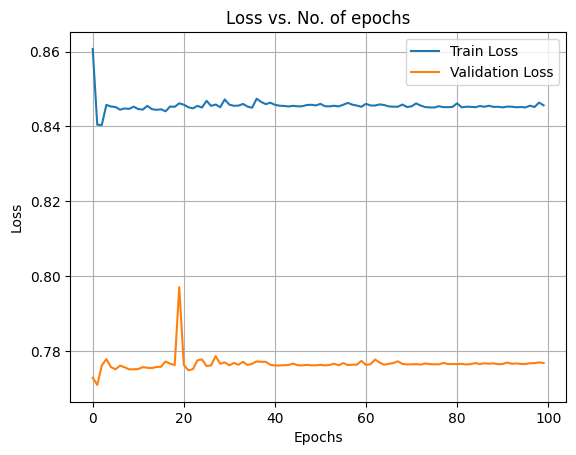

In [12]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [13]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [14]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_data,
    is_packed=False,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-14-4ee360ab307e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/content/{OUTPUT_MODEL_FILE_NAME}.pt').to(device)


Recall: 62.8815% | Total Accuracy: 49.0562%
Inference Time: 1s393ms
Inference Params: 7016449
